<font color="#138D75">**NERO Winter School training**</font> <br>
**Copyright:** (c) 2025 EUMETSAT <br>
**License:** GPL-3.0-or-later <br>
**Authors:** Andrea Meraner (EUMETSAT)
# Process MTG-FCI imagery data

## Intro

The MTG-FCI (Meteosat Third Generation - Flexible Combined Imager) is the latest and most advanced geostationary instrument launched by EUMETSAT in 2022. The data is available operationally since Dec 2024. The instrument offers 16 spectral channels in the visible and thermal infrared domain with spatial resolutions between 500m and 2km. The acquisition frequency is 10 minutes.

In this notebook, we will access and process L1c data (rectified radiances) from MTG-FCI using the satpy library. Satpy is a powerful tool for processing satellite data, and it includes readers for more than hundred satellite data format.

**Note:** Since the examples and case studies dates happened when FCI was not operational yet, the data is not publicly accessible. The EUMETSAT trainers have therefore uploaded the data to an S3-bucket dedicated to this training. Due to the data volume, the data is read remotely without downloading it locally into the JupyterHub instance (at cost of reduced processing speed).
For downloading data from the EUMETSAT Data Store using an optimised data download, see the script in `download_fci_from_archive.py` or [the MTG data access guide](https://user.eumetsat.int/resources/user-guides/mtg-data-access-guide).

## Learning Objectives

- How to work with geostationary FCI L1c data using satpy to generate composites

## Links and Resouces
- MTG-FCI information and L1c data guide: https://user.eumetsat.int/resources/user-guides/mtg-fci-level-1c-data-guide
- Youtube livestream showing the latest FCI images: https://www.eumetsat.int/real-time-imagery/earth-view
- Satpy documentation: https://satpy.readthedocs.io/en/stable/

<hr>

## Before we start
To run this script you need configure your access to the training s3-bucket. For this, you need to edit the credentials.py by entering the `S3_NERO_ACCESS_KEY` and `S3_NERO_SECRET_KEY` - please refer to Andrea or Dominika to get the keys.

<hr>

### Setup
Import the required packages and check the cache status

In [1]:
import os
from datetime import datetime, timedelta

import fsspec
from satpy import Scene
from satpy.readers import find_files_and_readers, FSFile

import credentials
from fci_satpy_script import CACHE_FOLDER, CACHE_SIZE_LIMIT_GB, main_fci, clear_cache_if_exceeds_limit

clear_cache_if_exceeds_limit(CACHE_FOLDER,
                             CACHE_SIZE_LIMIT_GB)  # the s3-bucket uses a cache folder, let's clean it up if it's full already

Configure your query by defining the time and area. The time should be in the format `"2024-09-16T00:00:00"` and will indicate the start time of the FCI acquisition. The latitude-longitude bounding box `lonlat_bbox` is generated from the `W`est, `S`outh, `E`ast, `N`orth variables.
**Note: since FCI provides an acquisition every 10 minutes (aka "repeat cycle"), the start time should be a round 10-min clock time, like 00:00, 00:10, 00:20, etc.**

In [2]:
start_time = "2024-09-16T11:00:00"

#  lat-lon geographical bounds of search area
W = 26.5
S = 41.7
E = 27.3
N = 42.3
lonlat_bbox = [W, S, E, N]

run_name = "testrun"
output_dir = "./test/"

input_dir = 'satellite_data/fci_data/202409_Portugal/'  # refer to the trainers for the correct path to the data depending on the case

### Search data on bucket
Let's find the FCI files for our query and prepare them for ingestion into a Satpy Scene.

In [3]:
start_dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S")

# initialise the filesystem for the bucket
fs = fsspec.filesystem(
    "simplecache",
    target_protocol="s3",
    target_options={
        "endpoint_url": credentials.S3_ENDPOINT,
        "key": credentials.S3_NERO_ACCESS_KEY,
        "secret": credentials.S3_NERO_SECRET_KEY,
    },
    cache_storage=CACHE_FOLDER
)

# search for files based on the start time
fci_filenames = find_files_and_readers(base_dir=f"s3://{credentials.S3_NERO_BUCKET_NAME}/{input_dir}",
                                       start_time=start_dt,
                                       end_time=start_dt + timedelta(minutes=10),
                                       reader='fci_l1c_nc',
                                       fs=fs,
                                       missing_ok=True)
# manually create FSFiles for each found path and pass that to the Scene
fci_filenames['fci_l1c_nc'] = [FSFile(fn, fs=fs) for fn in fci_filenames['fci_l1c_nc']]

if 'fci_l1c_nc' in fci_filenames and len(fci_filenames['fci_l1c_nc']) > 0:
    print(f"Found {len(fci_filenames['fci_l1c_nc'])} filenames: {fci_filenames['fci_l1c_nc']}")

Found 6 filenames: [<FSFile "training-nero/satellite_data/fci_data/202409_Portugal/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20240916111023_IDPFI_VAL_20240916110737_20240916110827_N__C_0067_0033.nc">, <FSFile "training-nero/satellite_data/fci_data/202409_Portugal/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20240916111045_IDPFI_VAL_20240916110803_20240916110856_N__C_0067_0035.nc">, <FSFile "training-nero/satellite_data/fci_data/202409_Portugal/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--CHK-BODY---NC4E_C_EUMT_20240916111037_IDPFI_VAL_20240916110755_20240916110842_N__C_0067_0034.nc">, <FSFile "training-nero/satellite_data/fci_data/202409_Portugal/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-HRFI-FD--CHK-BODY---NC4E_C_EUMT_20240916111037_IDPFI_VAL_20240916110755_20240916110842_N__C_0067_0034.nc">, <FSFile "training-nero/satellite_data/fci_data/202409_Portugal/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MT

### Initialise satpy Scene and generate composite
Now let's initialise the satpy Scene and check what datasets and composites can be extracted.

In [4]:
scn = Scene(filenames=fci_filenames)
scn.available_dataset_names()
scn.available_composite_names()

['24h_microphysics',
 'airmass',
 'ash',
 'cimss_cloud_type',
 'cimss_cloud_type_raw',
 'cloud_phase',
 'cloud_phase_distinction',
 'cloud_phase_distinction_raw',
 'cloud_phase_raw',
 'cloud_phase_with_night_ir105',
 'cloud_type',
 'cloud_type_with_night_ir105',
 'cloudtop',
 'colorized_ir_clouds',
 'convection',
 'day_essl_colorized_low_level_moisture',
 'day_essl_low_level_moisture',
 'day_microphysics',
 'dust',
 'essl_colorized_low_level_moisture',
 'essl_low_level_moisture',
 'fire_temperature',
 'fire_temperature_38refl',
 'fire_temperature_rad',
 'fog',
 'geo_color',
 'geo_color_background_with_low_clouds',
 'geo_color_high_clouds',
 'geo_color_low_clouds',
 'geo_color_night',
 'green_snow',
 'ir108_3d',
 'ir_cloud_day',
 'ir_sandwich',
 'ir_sandwich_with_night_colorized_ir_clouds',
 'natural_color',
 'natural_color_raw',
 'ndvi_hybrid_green',
 'ndvi_hybrid_green_fully_sunzencorrected',
 'ndvi_hybrid_green_raw',
 'night_fog',
 'night_ir105',
 'night_ir_alpha',
 'night_ir_with_ba

Out of the available dataset names, select the ones that interest you and add them to the list of datasets to load.
**Note: for many composites, you will may get a message saying that the dataset is not available and needs resampling. This is because composites combining channels of different spatial resolutions need to be resampled to a common grid first. We will do the resampling lower below, so you don't need to worry about the message now.

In [5]:
datasets = ['nir_22', 'ir_38', 'fire_temperature']
scn.load(datasets, upper_right_corner='NE')

The following datasets were not created and may require resampling to be generated: DataID(name='fire_temperature')


Now let's crop the datasets to our region of interest. All datasets will be cropped at the same time.
After that, we also resample the cropped data to the grid with the best available resolution. The `native` resampling simply splits or aggregates pixels to match a higher or lower resolution, without changing projection.

In [6]:
scn_crop = scn.crop(ll_bbox=lonlat_bbox)
scn_crop_r = scn_crop.resample(scn_crop.finest_area(), resampler='native', reduce_data=False)

Now let's visualise a dataset. The bucket contains only a subset of the FCI chunks (segments that compose the full-disc), namely the ones covering the area of interest for each case. Hence only part of the disc is available, and cropping to an area outside the area covered by the chunks will lead to an empty image.

/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


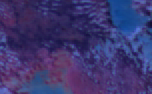

In [7]:
scn_crop_r.show('fire_temperature')

As final step, we save the datasets to our output folder. Single channels are saved with `enhance=False` in order to generate single-layer geotiffs with the original measured physical quantities array, rather than a grayscale RGB geotiffs.

In [8]:
output_dir = os.path.join(output_dir, run_name, 'Satellite_Imagery', 'FCI')
for ds in datasets:
    enhance = False if len(scn_crop_r[ds].shape) == 2 else True
    scn_crop_r.save_dataset(ds, filename="{start_time:%Y-%m-%dT%H%M}_mtg_fci_{name}.tif",
                            base_dir=output_dir, writer='geotiff', enhance=enhance)

## Automated processing for a given time range (optional)

Execute the cell below to automatically process every acquisition (repeat cycle) within a time frame.

In [9]:
start_time = "2024-09-16T11:00:00"  # should be a full 10-min time, like :00, :10, :20...
end_time = "2024-09-16T23:59:59"
remote_files = True
main_fci(input_dir, datasets, start_time, end_time, lonlat_bbox, output_dir, run_name, remote_files)

Processing 2024-09-16 11:00:00...
Found 6 filenames


The following datasets were not created and may require resampling to be generated: DataID(name='fire_temperature')
/tcenas/home/andream/anaconda3/envs/devenv/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))


Processing 2024-09-16 11:10:00...
Found 6 filenames


The following datasets were not created and may require resampling to be generated: DataID(name='fire_temperature')


Processing 2024-09-16 11:20:00...
Found 6 filenames


KeyboardInterrupt: 